# Main Notebook

In [1]:
import pandas as pd
import yfinance as yf

start_date = '2019-11-22'
end_date = '2023-07-31'
data = yf.download('GDLC', start=start_date, end=end_date, progress=False) #grabbing the data
#data.to_csv('data/raw/test.csv') 

df = pd.read_csv('data/raw/test.csv', parse_dates = True, index_col = 0)
df = df[['Adj Close']]
#df.to_csv('test_csv')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/raw/test.csv'

In [4]:
import pandas as pd
import numpy as np
import scipy
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline


ind = pd.read_csv("../src/data/Industry&Crypto.csv", header=0, index_col=0)/100
ind.index = pd.to_datetime(ind.index, format="%Y%m%d").to_period('D')
ind.columns = ind.columns.str.strip()
ind.columns, ind.shape, ind

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(Index(['NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils',
        'Shops', 'Hlth', 'Money', 'Other', 'GDLC'],
       dtype='object'),
 (925, 13),
              NoDur   Durbl   Manuf   Enrgy   Chems   BusEq   Telcm   Utils  \
 2019-11-25  0.0119  0.0212  0.0193  0.0169  0.0191  0.0175  0.0063  0.0027   
 2019-11-26  0.0029 -0.0020 -0.0002 -0.0229  0.0001 -0.0003 -0.0038  0.0002   
 2019-11-27  0.0046  0.0013  0.0014  0.0066  0.0022  0.0062  0.0089  0.0033   
 2019-11-29 -0.0002  0.0017 -0.0055 -0.0108 -0.0028 -0.0016  0.0034 -0.0044   
 2019-12-02 -0.0038 -0.0052 -0.0098 -0.0102 -0.0084 -0.0151 -0.0119 -0.0072   
 ...            ...     ...     ...     ...     ...     ...     ...     ...   
 2023-07-25 -0.0028 -0.0134 -0.0016  0.0021  0.0095  0.0031 -0.0145  0.0025   
 2023-07-26  0.0066  0.0092  0.0073 -0.0033  0.0031  0.0062  0.0059  0.0028   
 2023-07-27 -0.0114 -0.0249 -0.0085 -0.0119 -0.0115 -0.0153 -0.0098 -0.0181   
 2023-07-28  0.0067  0.0121  0.0154  0.016

In [5]:
#we should probably move these 3 functions to a separate .py file so we can call upon them when necessary

def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    return r.std()*(periods_per_year**0.5)

def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol

def minimize_vol(target_return, er, cov):
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq',
                        'args': (er,),
                        'fun': lambda weights, er: target_return - portfolio_return(weights,er)
    }
    weights = scipy.optimize.minimize(portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    return weights.x

In [6]:
industry_SR = sharpe_ratio(ind, 0.03, 260).sort_values()
industry_SR

Telcm    0.045508
GDLC     0.086774
NoDur    0.107925
Hlth     0.144737
Money    0.265801
Utils    0.278130
Other    0.480799
Durbl    0.481897
BusEq    0.511505
Manuf    0.561941
Shops    0.573557
Chems    0.580026
Enrgy    0.735096
dtype: float64

Expected returns, varcov matrix

In [7]:
def optimal_weights(n_points, er, cov):
    """
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

def plot_ef(n_points, er, cov):
    """
    Plots the multi-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov) # not yet implemented!
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style='.-')

def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    return (weights.T @ covmat @ weights)**0.5

def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns

<Axes: xlabel='Volatility'>

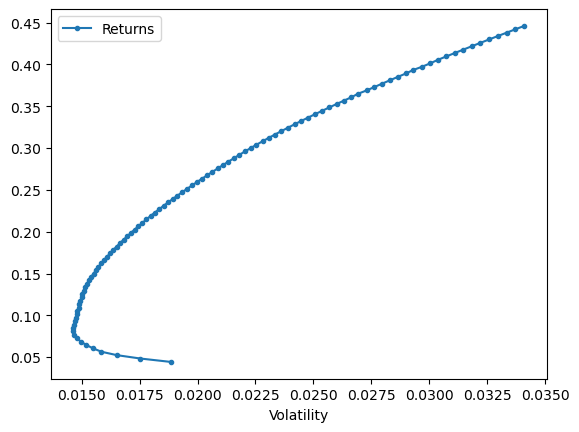

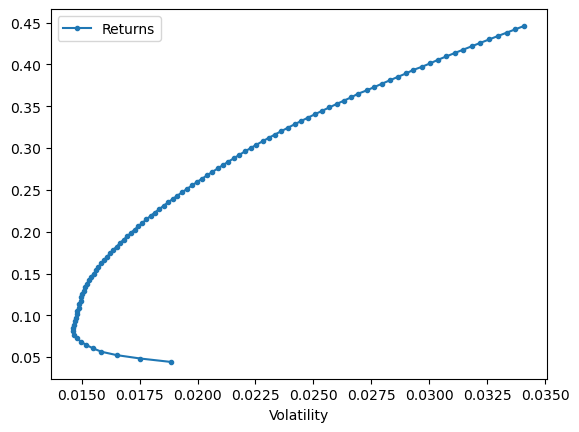

In [8]:
er = annualize_rets(ind, 260)
cov = ind.cov()
industry = ["NoDur", "Durbl",	"Manuf", "Enrgy", "Chems", "BusEq", "Telcm", "Utils", "Shops", "Hlth", "Money", "Other"]
industry_and_crypto = ["NoDur", "Durbl",	"Manuf", "Enrgy", "Chems", "BusEq", "Telcm", "Utils", "Shops", "Hlth", "Money", "Other", "GDLC"]

plot_ef(100, er[industry], cov.loc[industry,industry])
plot_ef(100, er[industry_and_crypto], cov.loc[industry_and_crypto,industry_and_crypto])

<AxesSubplot:xlabel='Volatility'>

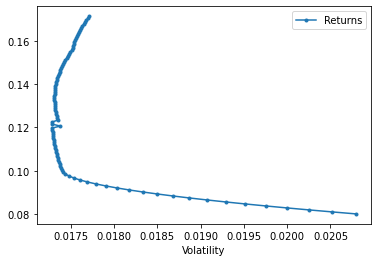

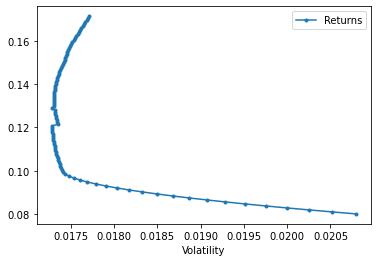

In [181]:
er = annualize_rets(ind, 260)
cov = ind.cov()
industry = ["Hlth", "Money", "Other"]
industry_and_crypto = ["Hlth", "Money", "Other", "GDLC"]
plot_ef(100, er[industry], cov.loc[industry,industry])
plot_ef(100, er[industry_and_crypto], cov.loc[industry_and_crypto,industry_and_crypto])

In [10]:
def plot_ef(n_points, er, cov, ax=None):
    """
    Plots the multi-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov) # not yet implemented!
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    if ax is None:
        ax = ef.plot.line(x="Volatility", y="Returns", style='.-')
    else:
        ef.plot.line(x="Volatility", y="Returns", style='.-', ax=ax)
    return ax


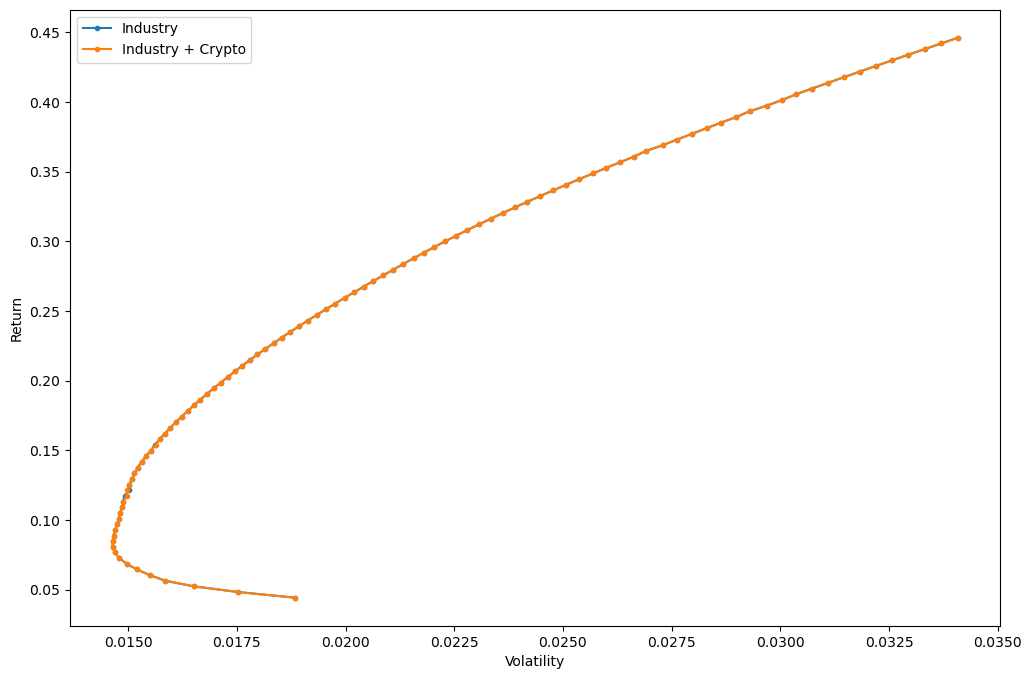

In [11]:
fig, ax = plt.subplots(figsize=(12, 8)) # Create a figure and a set of subplots

# Plot the efficient frontier for just the industries
plot_ef(100, er[industry], cov.loc[industry,industry], ax)

# Plot the efficient frontier for industries and crypto
plot_ef(100, er[industry_and_crypto], cov.loc[industry_and_crypto,industry_and_crypto], ax)

# Add labels and legend
ax.set_xlabel('Volatility')
ax.set_ylabel('Return')
ax.legend(["Industry", "Industry + Crypto"])

plt.show()
